In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from glob import glob
sys.path.append('../scripts/')
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from dask import delayed

from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import alphabet

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.2)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [3]:
def read_dataset(file):
    return xr.open_dataset(file,autoclose=True)

def preprocess(ds):
    dsnew = ds.copy()
    dsnew = mad_wrapper(dsnew,p)
    dsnew = threshold_for_chi(dsnew,p)
    dsnew = rm_sensor_malfunction(dsnew,p)
    dsnew = combine_two_sensors(dsnew,p)
    
    dsnew = dsnew.drop(['k_rpm','k_cpm','f_cps','f_rps','noise_cps','noise_rpm',
                 'snr1','snr2','corrdTdzsp1_rpm','corrdTdzsp2_rpm',
                 'bat1_rc','bat2_rc','bat1','bat2','kra1','kra2',
                 'power1','power2','dof'])
    dsnew = dsnew.drop(['A1','A2','b1','b2','l1','l2'])
    return dsnew

def interpolate_z(ds):
    newz = np.linspace(-1950,0,1000)
    ds['times'] = ds.time
    ds['starttime'] = ds.time.min()
    ds = ds.swap_dims({'time':'z'})
    _, index = np.unique(ds.z.dropna('z'), return_index=True)
#     print(index.size)
    return ds.isel(z=index).interp(z=newz)

def plot_sections(ds,label):

    f,ax = plt.subplots(2,1,figsize=(10,5), sharex=True)

    ds.sortby('starttime').eps1_kra.pipe(np.log10).plot(vmin=-10,vmax=0, ax=ax[0])
    ax[0].set_ylim(-500,0)
    ax[0].set_xlabel(None)

    ds.sortby('starttime').eps_rc.pipe(np.log10).plot(vmin=-10,vmax=0, ax=ax[1])
    ax[1].set_ylim(-500,0)

    plt.savefig(f'../figures/section_plots/eps_kra_{label}.pdf');

../data/niw2017/7785b
7785b
done with ../data/niw2017/7785b!
../data/niw2017/7700b
7700b
done with ../data/niw2017/7700b!
../data/niw2017/7786b
7786b
done with ../data/niw2017/7786b!
../data/niw2017/7784b
7784b
done with ../data/niw2017/7784b!
../data/niw2017/7701b
7701b
done with ../data/niw2017/7701b!
../data/niw2017/7780b
7780b
done with ../data/niw2017/7780b!


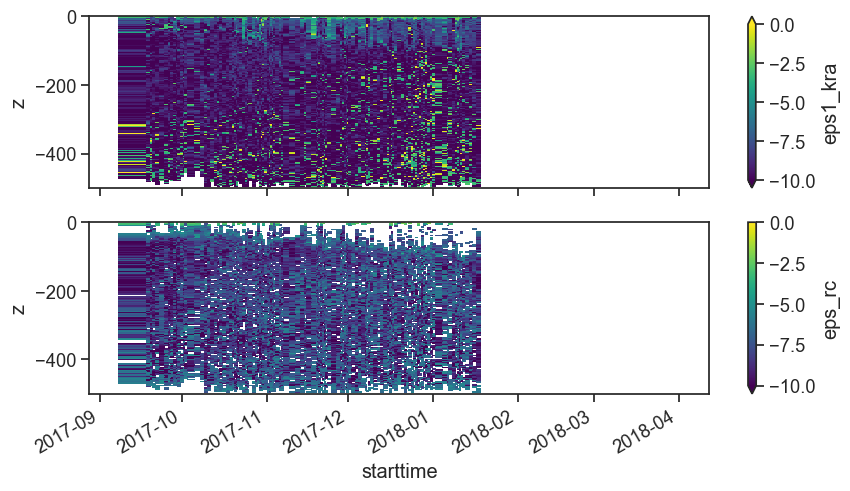

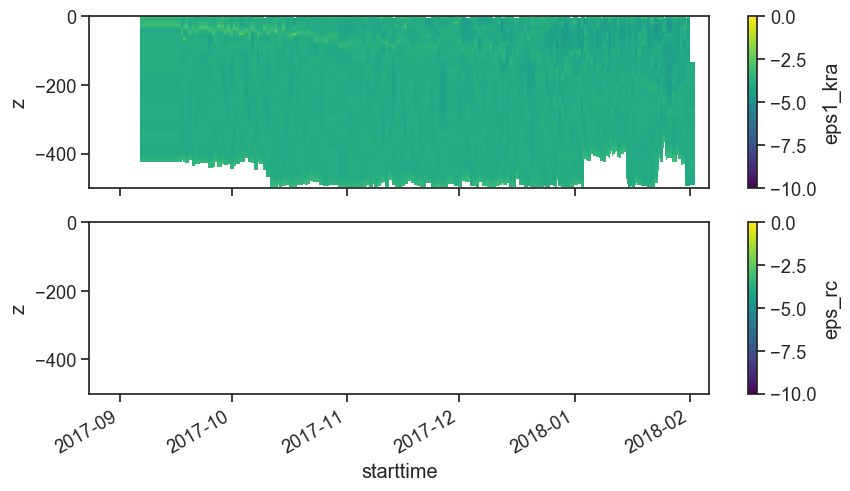

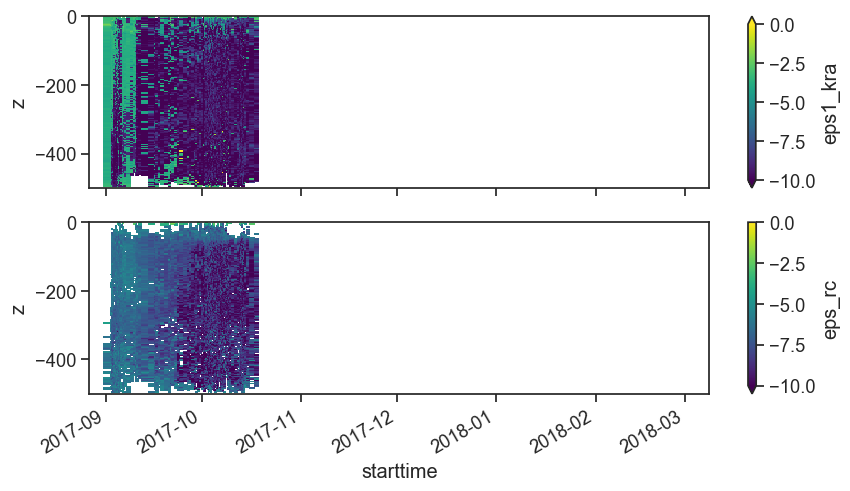

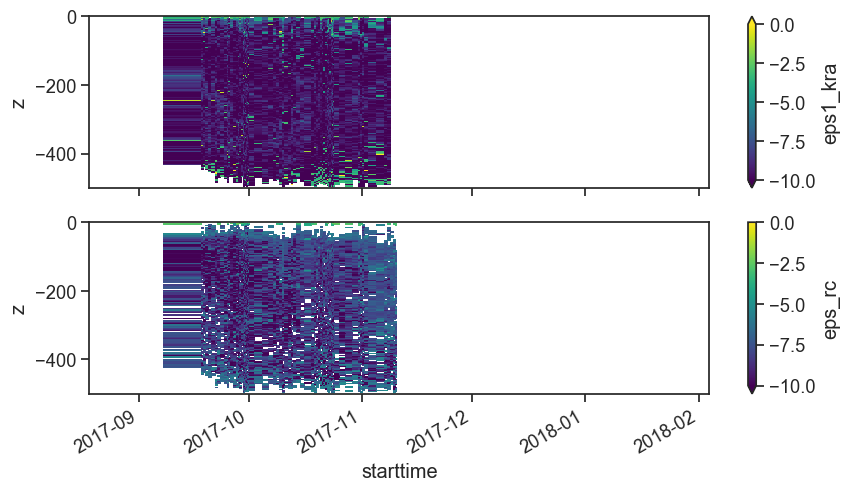

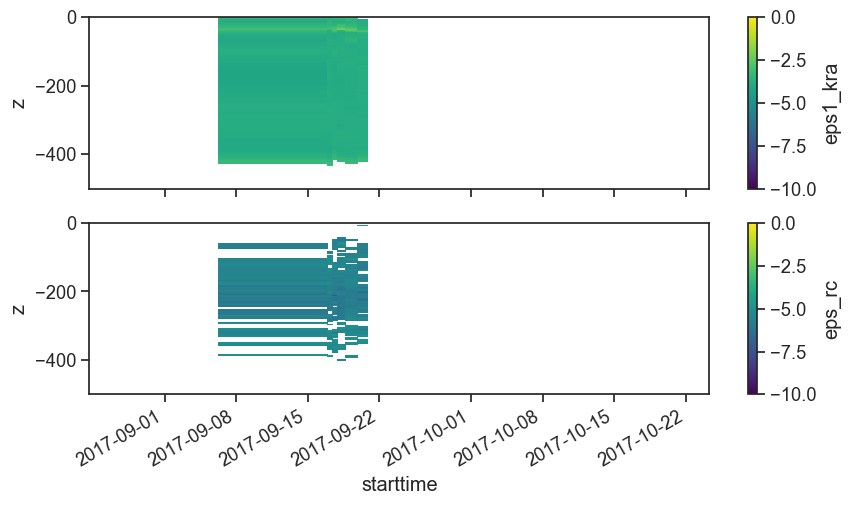

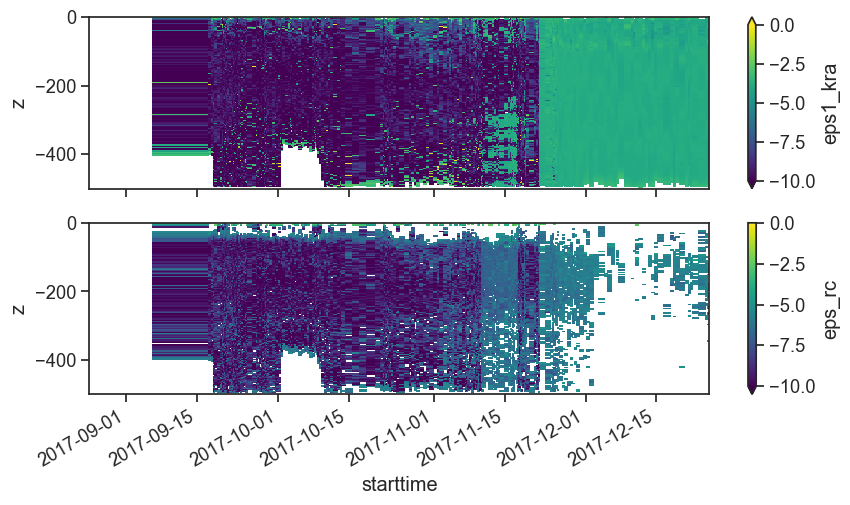

In [4]:
years = ['niw2017']
for year in years:
    for direct in glob('../data/'+year+'/*'):
        print(direct)
        label = direct.split('/')[-1]
        print(label)
        datasets = [read_dataset(file) for file in glob(direct+'/ema*.nc')]
        ds0 = [preprocess(dataset) for dataset in datasets]
        ds1 = [interpolate_z(dataset) for dataset in ds0]
        ds = xr.concat(ds1, dim='starttime').transpose()
        plot_sections(ds,label)
        ds.to_netcdf(direct+'/'+label+'.nc')
        print(f'done with {direct}!')